In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import config, torch

plt.style.use('seaborn-v0_8')

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import DLR_HySU
dataset = DLR_HySU(root_dir=os.path.join(config.DLR_HySU_PATH,'mat'), transform=None) 

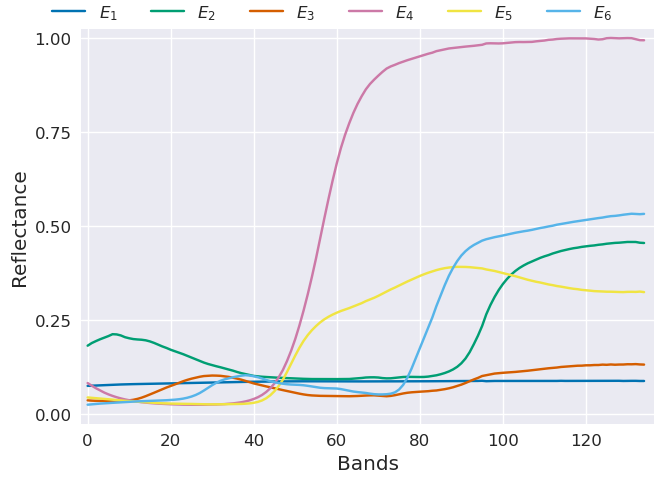

In [3]:
from utils import plot_endmembers, show_abundance

fig = plot_endmembers(dataset.endmembers())
plt.show()

# fig = show_abundance(dataset.abundance())
# plt.show()

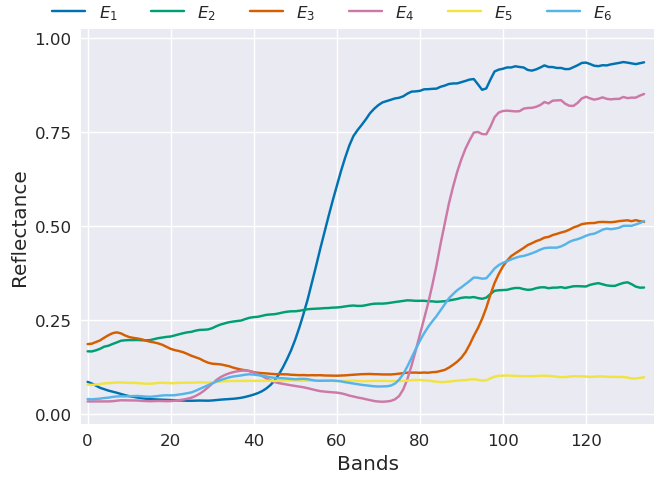

In [49]:
from pysptools import eea
n_endmembers = dataset.n_endmembers
# n_endmembers = 6

ee = eea.NFINDR()
endmember = ee.extract(dataset.image().numpy(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)

In [50]:
# # save endmember_init
# # torch.save(endmember_init, 'hysu_endmember_init.pt')

# # load endmember_init
# n_endmembers = dataset.n_endmembers
# endmember_init = torch.load('hysu_endmember_init.pt')
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

In [51]:
dataset.X.max()

tensor(0.9360)

# Train

In [52]:
from torch import nn
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))
    print(vol_reg_norm)
    


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [53]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [54]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(0.0696), tensor(1.0410))

In [55]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=25, lr=1e-3, simplex_weight=1e-2)

tensor(0.0696, device='cuda:0')


100%|██████████| 25/25 [00:14<00:00,  1.78epoch/s, tls=0.0824]


In [56]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0358) tensor(0.8442) tensor(1.4560e-06) tensor(0.7170)


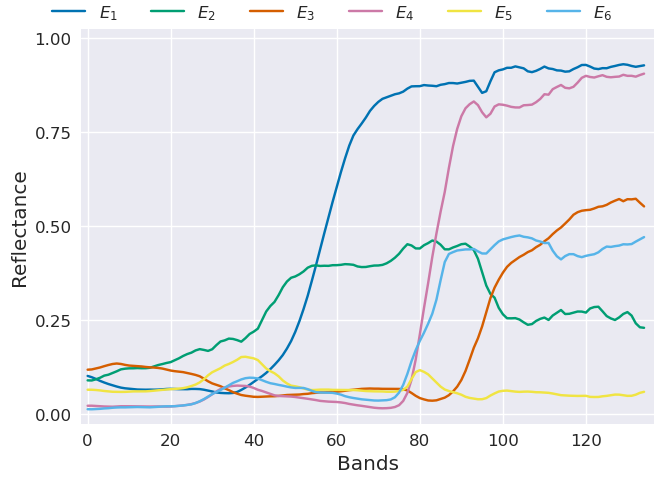

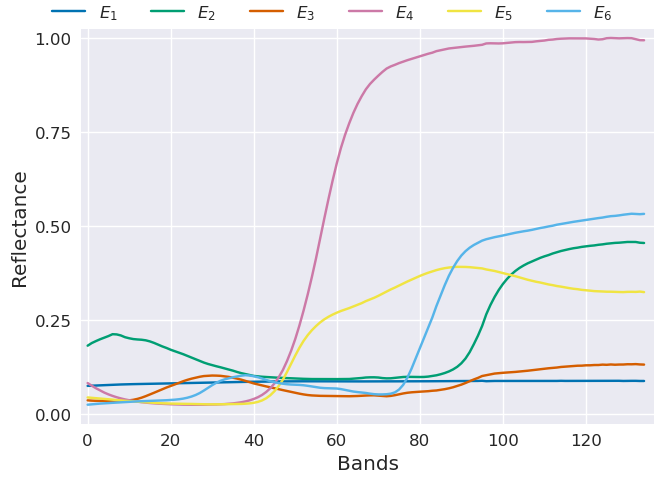

In [57]:
ebk = sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk)
plt.show(fig)

fig = plot_endmembers(dataset.endmembers())
plt.show(fig)

In [71]:
from scipy import io as sio
# data = sio.loadmat(os.path.join(config.DLR_HySU_PATH,'mat','large_targets.mat'))
data = sio.loadmat(os.path.join(config.DLR_HySU_PATH,'mat','all_targets.mat'))
data.keys()

_X = torch.tensor(data['X']).float()
_X = _X /(_X.max() + 1e-3)
n_rows, n_cols, n_bands = _X.shape
_X = _X.reshape(-1, n_bands)
# _X = dataset.X



model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0772) tensor(0.8548) tensor(1.4560e-06) tensor(0.7170)


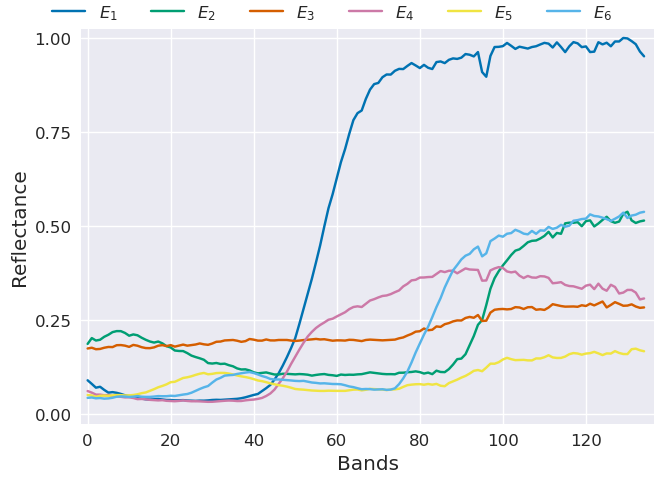

In [72]:
from pysptools import eea
n_endmembers = dataset.n_endmembers
# n_endmembers = 6

ee = eea.NFINDR()
endmember = ee.extract(_X.reshape(n_rows, n_cols, n_bands).numpy(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)

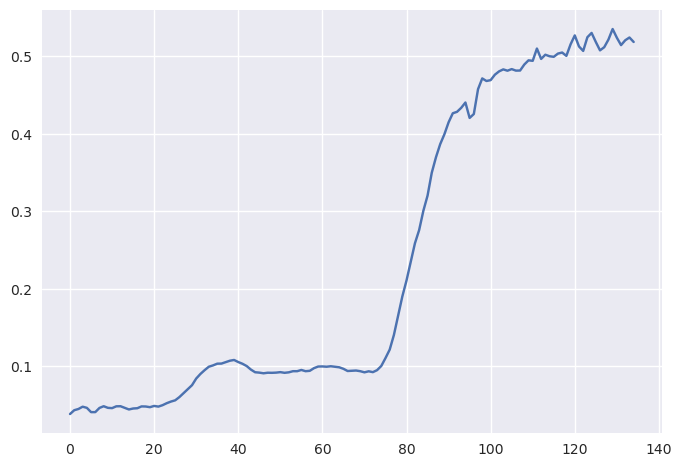

In [64]:
plt.plot(_X[25])
plt.show()

In [67]:
_X.max()

tensor(1.0000)

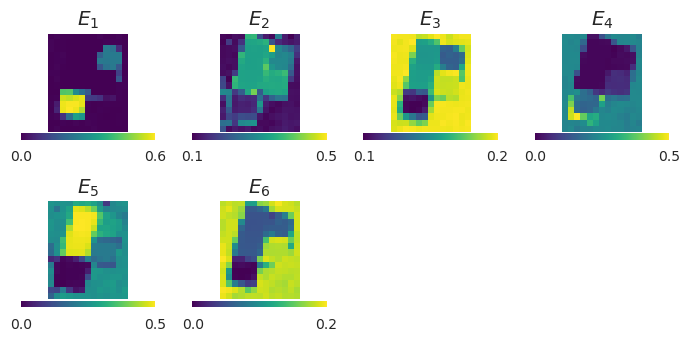

In [59]:
from torch.nn.functional import softmax

# test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(n_rows, n_cols, -1)

fig = show_abundance(test)
# fig.savefig('abundance.png', dpi=300, bbox_inches='tight')
plt.show(fig)

In [60]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

# reorder the endmembers
# endmembers = endmembers[idx]

tensor([[0.5828, 0.5616, 0.5423, 0.0400, 0.1125, 0.4433],
        [0.3502, 0.7559, 0.5586, 0.4895, 0.3962, 0.7493],
        [0.7475, 0.2124, 0.4873, 0.6279, 0.6810, 0.3647],
        [0.8171, 0.4588, 0.5688, 0.5134, 0.5584, 0.1171],
        [0.3621, 0.8021, 0.5453, 0.8795, 0.8192, 0.9381],
        [0.7254, 0.4542, 0.5031, 0.4429, 0.4696, 0.0975]])
tensor([3, 0, 1, 5, 0, 5])


In [ ]:
plt.imshow(dataset.image()[:,:,25].T,cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
from scipy import io
data = io.loadmat(os.path.join(config.DLR_HySU_PATH,'mat','all_targets.mat'))
data['X'].shape

n_col, n_row, n_bands = data['X'].shape
X = data['X'].reshape(-1, data['X'].shape[-1], order='F')

plt.imshow(X.reshape(n_row, n_col, -1)[:,:,10].T, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
all_targerts = {
    'Y': X,
    'nRow': n_row,
    'nCol': n_col,
    'nBand': n_bands,
    'maxValue': X.max(),
    'wavelength': dataset.wv
}

io.savemat(os.path.join(config.DLR_HySU_PATH,'mat','all_targets_v2.mat'), all_targerts)

In [ ]:
dataset.wv

In [ ]:
io.loadmat(os.path.join(config.DLR_HySU_PATH,'mat','dlr_hysu_R135.mat')).keys()

In [ ]:
PATH = '/home/abian/Data/Dataset/HSI/DLR_HySU/Matlab/'

import scipy.io as sio
A = sio.loadmat(PATH+'A.mat')

material = list(A.keys())[3:]

plt.figure(figsize=(20,10))
for i in range(len(material)):
    plt.subplot(2,5,i+1)
    plt.imshow(A[material[i]].T, cmap='viridis')
    plt.axis('off')
    plt.title(material[i])

plt.show()

In [ ]:
mat = sio.loadmat(PATH+'full.mat')
keys = list(mat.keys())[3:]

print(keys)
X = mat[keys[0]]
wv = mat[keys[1]]
print(wv)
plt.imshow(X[:,:,100].T, cmap='gray')
plt.imshow(A['redMetal'].T, cmap='viridis', alpha=0.5)
plt.axis('off')
# n_row, n_col, n_band = mat[keys[1]].item(), mat[keys[2]].item(), mat[keys[3]].item()
# # print(n_row)
# X = mat[keys[0]].reshape(n_row, n_col, n_band)
# print(X.shape)
# wv = mat[keys[1]]

# plt.imshow(X[:,:,100].T, cmap='gray')
# plt.imshow(A['redMetal'].T, cmap='viridis', alpha=0.5)
# plt.axis('off')

# to_save = {'X': X, 'wavelength': _wv}
# sio.savemat(PATH+'full.mat', to_save)

In [ ]:
all_targets = sio.loadmat(PATH+'all_targets.mat')
keys = list(mat.keys())[3:]
print(keys)
_wv = all_targets['wavelength']
_wv
# print(keys)
# # n_row, n_col, n_band = mat[keys[1]].item(), mat[keys[2]].item(), mat[keys[3]].item()
# # print(n_row)
# X = mat[keys[0]].reshape(n_row, n_col, n_band)
# print(X.shape)
# wv = mat[keys[1]]

# plt.imshow(X[:,:,100].T, cmap='gray')
# plt.imshow(A['redMetal'].T, cmap='viridis', alpha=0.5)
# plt.axis('off')

In [ ]:
keys

In [ ]:
import pandas as pd
csv = pd.read_csv(PATH+'DLR_HySU_SVC_ASCII.csv')

signatures = csv.iloc[:, 1:7].to_numpy()
signatures = signatures / (signatures.max() + 1e-3)
material = csv.columns[1:7]

In [ ]:
from utils import plot_endmembers

fig = plot_endmembers(signatures.T, wv.reshape(-1)*1e3, material)
plt.show()

In [ ]:
mat = sio.loadmat(PATH+'full.mat')
X = mat['X'] / (mat['X'].max() + 1e-3)
original_shape = X.shape
X = X.reshape(-1, X.shape[-1])

from HySpecLab.eea import VCA
n_endmembers = 6

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=128)
vca.fit(X)
E = vca.endmembers()
# endmember_init = torch.from_numpy(vca.endmembers()).float()

In [ ]:
fig = plot_endmembers(E, wv.reshape(-1)*1e3, material)
# plt.show().shape

In [ ]:
print(signatures.T.shape, E.shape)

In [ ]:
from HySpecLab.metrics import sad
import torch
_signatures = torch.from_numpy(signatures.T).float()
_E = torch.from_numpy(E).float()

sad_result = sad(_signatures, _E)


idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
sad_result, idx

In [ ]:
# Urban dataset


In [ ]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

In [ ]:
from scipy import io as sio
import os
data_jr = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
gt_jr = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'GroundTruth/end4.mat'))

In [ ]:
data_jr.keys(), gt_jr.keys()

In [ ]:
data_jr['Y'].shape, data_jr['nRow'], data_jr['nCol']

In [ ]:
DLR_HySU_PATH = '/home/abian/Data/Dataset/HSI/DLR_HySU/Matlab/'

data = sio.loadmat(os.path.join(DLR_HySU_PATH, 'full.mat'))
data['X'].shape
n_row, n_col, n_bands = data['X'].shape


In [ ]:
my_data = {}
my_data['Y'] = data['X'].reshape(-1, n_bands).T
my_data['nRow'] = n_row
my_data['nCol'] = n_col
my_data['nBand'] = n_bands
my_data['maxValue'] = data['X'].max()
my_data['wavelength'] = data['wavelength']

sio.savemat(os.path.join(DLR_HySU_PATH, 'dlr_hysu_R135.mat'), my_data)

In [ ]:
test = sio.loadmat(os.path.join(DLR_HySU_PATH, 'dlr_hysu_R135.mat'))
test

n_row, n_col, n_band = test['nRow'].item(), test['nCol'].item(), test['nBand'].item()
plt.imshow(test['Y'].T.reshape(n_row, n_col, n_band)[:,:,100].T, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
masks = sio.loadmat(os.path.join(DLR_HySU_PATH, 'masks.mat'))
print(masks.keys())

In [ ]:
plt.imshow(masks['materials'][:,:,2].T, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
A = sio.loadmat(os.path.join(DLR_HySU_PATH, 'A.mat'))
print(A.keys())

plt.imshow(A['blueFabric'].T, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
np.unique(A['blueFabric'])

materials = list(A.keys())[3:]
material_idx = []
# Intersection over Union
def iou(pred, target):
    intersection = (pred & target).sum(axis=(0,1))
    union = (pred | target).sum(axis=(0,1))
    return intersection / union

for material in materials:
    print(material)
    _A = A[material]
    _A = _A.reshape(*_A.shape, 1)
    _A = np.repeat(_A, masks['materials'].shape[-1], axis=2)

    iou_result = iou(_A, masks['materials'])
    material_idx.append(np.argmax(iou_result))
    print(iou_result)
    
print(material_idx)

In [ ]:
# gt = {}
# gt['cood'] = materials


# print(A['materials'])


In [ ]:
A_result = []
material_idx = []
for i, material in enumerate(materials):
    print(material)
    A_result.append(A[material])
    _A = A[material]
    _A = _A.reshape(*_A.shape, 1)
    _A = np.repeat(_A, masks['materials'].shape[-1], axis=2)

    iou_result = iou(_A, masks['materials'])
    material_idx.append(np.argmax(iou_result))
    print(iou_result)

print(material_idx)
A_result = np.stack(np.array(A_result), axis=0)
_masks = masks['materials']
_masks = _masks[:,:,material_idx]
# reorder
# A_result = A_result[material_idx]
# print(A_result.shape)
for i in range(5):
    _A = A_result[i]
    print(_A.shape)
    _A = _A.reshape(*_A.shape, 1)
    _A = np.repeat(_A, _masks.shape[-1], axis=2)

    iou_result = iou(_A, _masks)
    print(iou_result)

In [ ]:
gt_jr['A'].shape

In [ ]:
A_result = A_result.reshape(len(materials), -1)
print(A_result.shape)

In [ ]:
import pandas as pd
csv = pd.read_csv(PATH+'DLR_HySU_SVC_ASCII.csv')

E = []
for idx, material in enumerate(materials):
    E.append(csv.loc[:, material])

E.append(csv.loc[:, 'grass'])
E = np.stack(np.array(E), axis=0)
print(E.shape)

In [ ]:
gt = {'cood': materials + ['grass'], 'A': A_result, 'M': E.T}
sio.savemat(os.path.join(DLR_HySU_PATH, 'gt.mat'), gt)

In [ ]:
materials

In [ ]:
# load gt
gt = sio.loadmat(os.path.join(DLR_HySU_PATH, 'gt.mat'))
print(gt.keys())
gt['cood'][0]

In [ ]:
A_result.shape, E.shape

In [ ]:
gt_jr['A'].shape, gt_jr['M'].shape

In [ ]:
csv.columns

In [ ]:
print(gt_jr['M'].max())

In [ ]:
gt_jr['A'].shape

In [ ]:
data_jr['Y'].shape

In [ ]:
# Intersection over Union
def iou(pred, target):
    intersection = (pred & target).sum(axis=(0,1))
    union = (pred | target).sum(axis=(0,1))
    return intersection / union

iou(A['blueFabric'], masks['materials'][:,:,2])

In [ ]:
B, C = A['greenFabric'], masks['materials']

print(B.shape)

# Broadcast B as C shape
B = B.reshape(*B.shape, 1)
B = np.repeat(B, C.shape[-1], axis=2)

intersection = (B & C).sum(axis=(0,1))
union = (B | C).sum(axis=(0,1))
intersection/union

In [ ]:
full = sio.loadmat(os.path.join(DLR_HySU_PATH, 'full.mat'))

In [ ]:
plt.imshow(data['X'][:,:,100].T)

# Dataset

In [ ]:
import torch
from dataset import HSIDataset
from torch import tensor

class DLR_HySU(HSIDataset):
    '''
        DLR_HySU Dataset.

        Cerra, D., Pato, M., Alonso, K., Köhler, C., Schneider, M., de los Reyes, R., ... & Müller, R. (2021). 
        Dlr hysu—a benchmark dataset for spectral unmixing. Remote Sensing, 13(13), 2559.
        
        Attributes:
        ----------
            n_row: int
                Number of rows.
            n_col: int
                Number of columns.
            n_bands: int
                Number of bands.
            wv: ndarray, shape (n_bands)
                Wavelength in μm (1e-6).
            X: Tensor, shape (n_row*n_col, n_bands)
                hyperspectral Cube.
            E: Tensor, shape (n_materials, n_bands)
                Endmembers of the different material, Grass included.
            A: Tensor, shape (n_row*n_col, n_materials-1) 
                Abundance maps without the grass.

    '''
    def __init__(self, root_dir, transform=None):
        super(DLR_HySU, self).__init__()

        data = sio.loadmat(os.path.join(root_dir, 'dlr_hysu_R135.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'gt.mat'))

        self.n_row, self.n_col , self.n_bands = data['nRow'].item(), data['nCol'].item(), data['nBand'].item()
        self.wv = data['wavelength'].T.reshape(-1)

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.E = self.E / (self.E.max() + 1e-3)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_endmembers = self.E.shape[0]
        
        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)

In [ ]:
dataset = DLR_HySU('/home/abian/Data/Dataset/HSI/DLR_HySU/mat/')
dataset.wv.shape

In [ ]:
test = dataset.image()
plt.imshow(test[:,:,100].T, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
X = dataset.X.numpy()

from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)
vca.fit(X)
E = vca.endmembers()

In [ ]:
from utils import plot_endmembers
fig = plot_endmembers(E, wv=dataset.wv*1e3)
plt.show(fig)

In [ ]:
plt.plot(dataset.endmembers().T)
plt.show()

In [ ]:
from HySpecLab.metrics import sad

sad_result = sad(dataset.endmembers(), torch.tensor(E))
idx = torch.argmin(sad_result, axis=1)

print(sad_result)
print(idx)